# Caribbean - Single-beam bathymetry

This dataset is a compilation of several single-beam bathymetry surveys of the
Caribbean ocean displaying a wide range of tectonic activity and uneven
distribution.

**Source:** [NOAA NCEI](https://ngdc.noaa.gov/mgg/geodas/trackline.html)

**License:** [public domain](https://ngdc.noaa.gov/ngdcinfo/privacy.html)

## Notes

The original data file was compressed with LZMA to save space and make it
possible to upload it to this GitHub repository (see `raw/`) since there is not
direct download link we could use.

The raw data are in MGD77 format and include a header with metadata on each survey ([`MGD77_921744.h77t`](MGD77_921744.h77t))

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

## Read the data

Use pandas to read the data.

In [2]:
data_full = pd.read_csv(
    Path("raw") / "MGD77_921744.m77t.xz", 
    sep="\t", 
    usecols=[0, 4, 5, 9],
    dtype=dict(SURVEY_ID="str", LON="float64", LAT="float64", CORR_DEPTH="float64"),
).dropna().reset_index(drop=True)
data_full = data_full.rename(
    columns=dict(
        SURVEY_ID="survey_id", 
        LAT="latitude",
        LON="longitude", 
        CORR_DEPTH="bathymetry_m",
    )
)
data_full.bathymetry_m *= -1
data_full

,survey_id,latitude,longitude,bathymetry_m
0,FM0501,24.77290,-89.58530,-3559.0
1,FM0501,24.76070,-89.57550,-3561.0
2,FM0501,24.74840,-89.56560,-3555.0
3,FM0501,24.73600,-89.55570,-3553.0
4,FM0501,24.72380,-89.54580,-3553.0
...,...,...,...,...
2354729,EW0003,9.92284,-84.72557,-20.0
2354730,EW0003,9.92282,-84.72565,-20.0
2354731,EW0003,9.92283,-84.72570,-20.0
2354732,EW0003,9.92284,-84.72574,-21.0


There is quite a bit of data so we want to slice it a bit to cover a smaller area where the bathymetry is more interesting.

In [3]:
region_latlon = (-68, -57, 9, 17)
data_cropped = data_full[vd.inside((data_full.longitude, data_full.latitude), region=region_latlon)].reset_index(drop=True)
data_cropped

,survey_id,latitude,longitude,bathymetry_m
0,86005311,16.09652,-61.52117,-187.0
1,86005311,16.09415,-61.52104,-177.0
2,86005311,16.09177,-61.52091,-185.0
3,86005311,16.08940,-61.52078,-188.0
4,86005311,16.08703,-61.52066,-192.0
...,...,...,...,...
472812,JR336,15.28529,-57.01258,-5275.9
472813,JR336,15.28705,-57.00994,-5276.9
472814,JR336,15.28883,-57.00732,-5277.8
472815,JR336,15.29057,-57.00467,-5277.0


Remove the following surveys because their data show up with much larger depths than the surrounding data and some of the denser surveys that make this dataset quite large.

In [4]:
surveys_to_remove = [
    "OPR425OB",
    "OPR425R1",
    "OPR425OB",
    "OPR425RC",
    "OPR425RB",
    "KA68H",
    "BA68003M",
    "RP0269",
    "S586CB",
    # These are now just to make the data a bit smaller
    "81002711",
    "CD7593",
    "RC2907",
    "80003411",
    "RC2605",
    "RC2603",
    "RC0903",
    "PLUM07WT",
]
data = data_cropped[~data_cropped.survey_id.isin(surveys_to_remove)].reset_index(drop=True)
data

,survey_id,latitude,longitude,bathymetry_m
0,86005311,16.09652,-61.52117,-187.0
1,86005311,16.09415,-61.52104,-177.0
2,86005311,16.09177,-61.52091,-185.0
3,86005311,16.08940,-61.52078,-188.0
4,86005311,16.08703,-61.52066,-192.0
...,...,...,...,...
294316,JR336,15.28529,-57.01258,-5275.9
294317,JR336,15.28705,-57.00994,-5276.9
294318,JR336,15.28883,-57.00732,-5277.8
294319,JR336,15.29057,-57.00467,-5277.0


## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

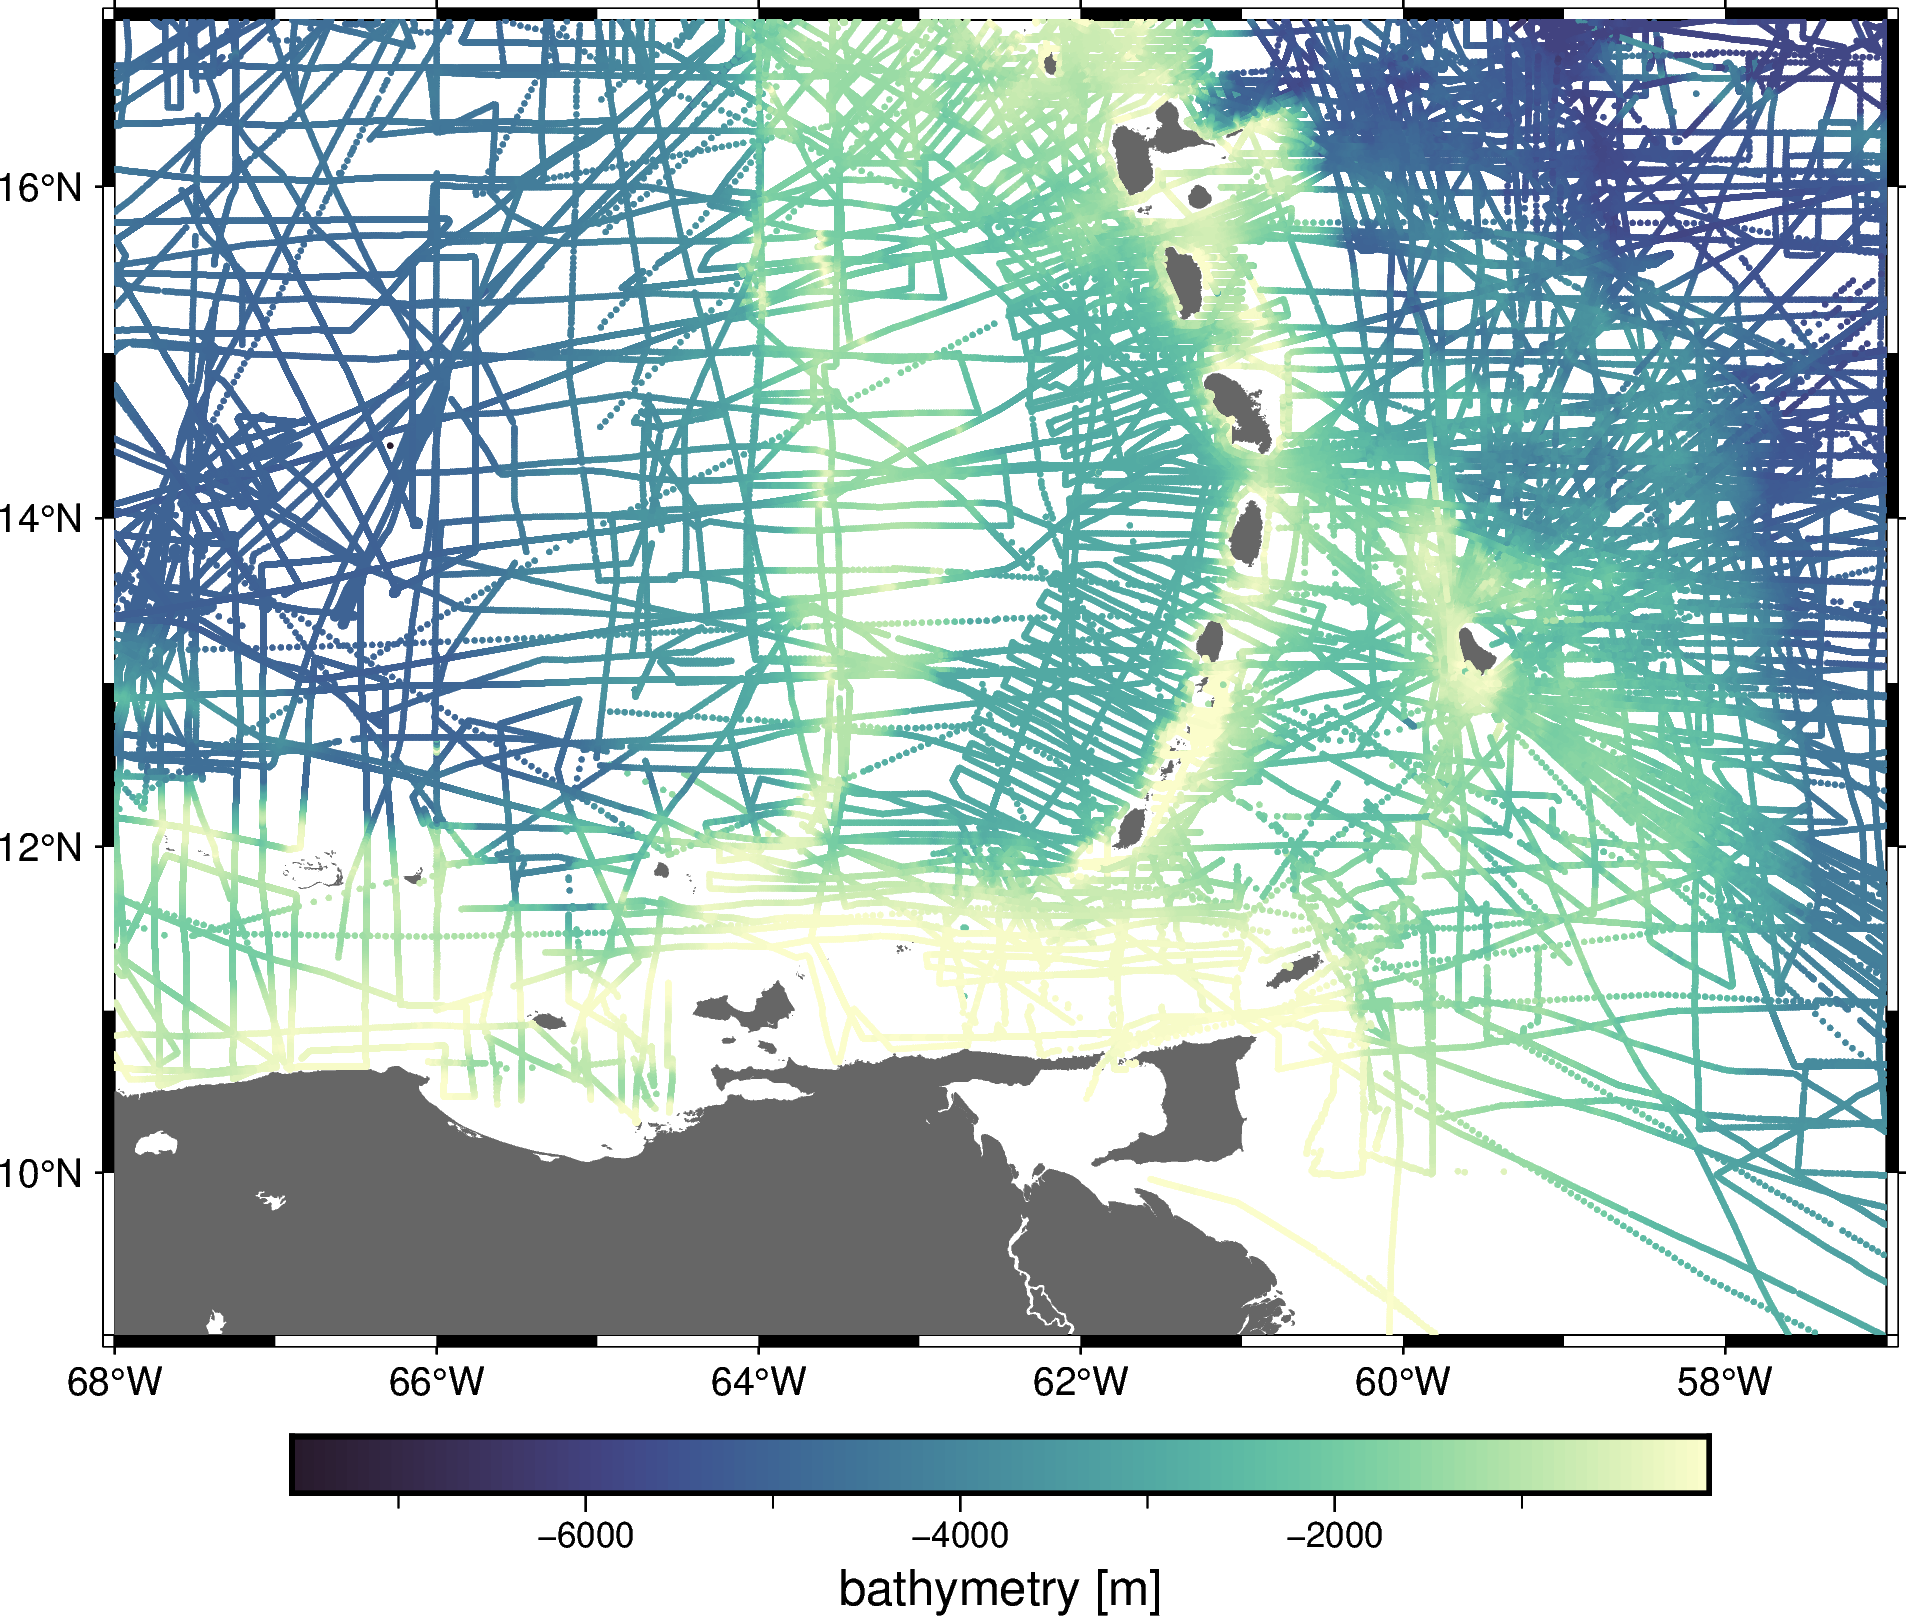

In [5]:
region = vd.get_region((data.longitude, data.latitude))

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame="af")
fig.coast(land="#666666")
pygmt.makecpt(cmap="cmocean/topo+h", series=[data.bathymetry_m.min(), data.bathymetry_m.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.bathymetry_m,
    cmap=True,
    style="c0.05c",
)
fig.colorbar(frame='af+l"bathymetry [m]"')
fig.savefig("preview.jpg", dpi=200)
fig.show(width=800)

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

In [6]:
export = pd.DataFrame({
    "survey_id": data.survey_id,
    "latitude": data.latitude.map(lambda x: "{:.5f}".format(x)),
    "longitude": data.longitude.map(lambda x: "{:.5f}".format(x)), 
    "bathymetry_m": data.bathymetry_m.map(lambda x: "{:.0f}".format(x)), 
})
export

,survey_id,latitude,longitude,bathymetry_m
0,86005311,16.09652,-61.52117,-187
1,86005311,16.09415,-61.52104,-177
2,86005311,16.09177,-61.52091,-185
3,86005311,16.08940,-61.52078,-188
4,86005311,16.08703,-61.52066,-192
...,...,...,...,...
294316,JR336,15.28529,-57.01258,-5276
294317,JR336,15.28705,-57.00994,-5277
294318,JR336,15.28883,-57.00732,-5278
294319,JR336,15.29057,-57.00467,-5277


Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [7]:
output = "caribbean-bathymetry.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: caribbean-bathymetry.csv.xz
size: 1.255272 Mb
md5:79698c447daba7c15011a5528c8fe212
sha256:f90d5d34309df866321676efdea5ef4817fe71534c7190d3b495a33efd2dd20e


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [8]:
data_reloaded = pd.read_csv(output)
data_reloaded

,survey_id,latitude,longitude,bathymetry_m
0,86005311,16.09652,-61.52117,-187
1,86005311,16.09415,-61.52104,-177
2,86005311,16.09177,-61.52091,-185
3,86005311,16.08940,-61.52078,-188
4,86005311,16.08703,-61.52066,-192
...,...,...,...,...
294316,JR336,15.28529,-57.01258,-5276
294317,JR336,15.28705,-57.00994,-5277
294318,JR336,15.28883,-57.00732,-5278
294319,JR336,15.29057,-57.00467,-5277


Make the figure again but don't save it to a file this time.

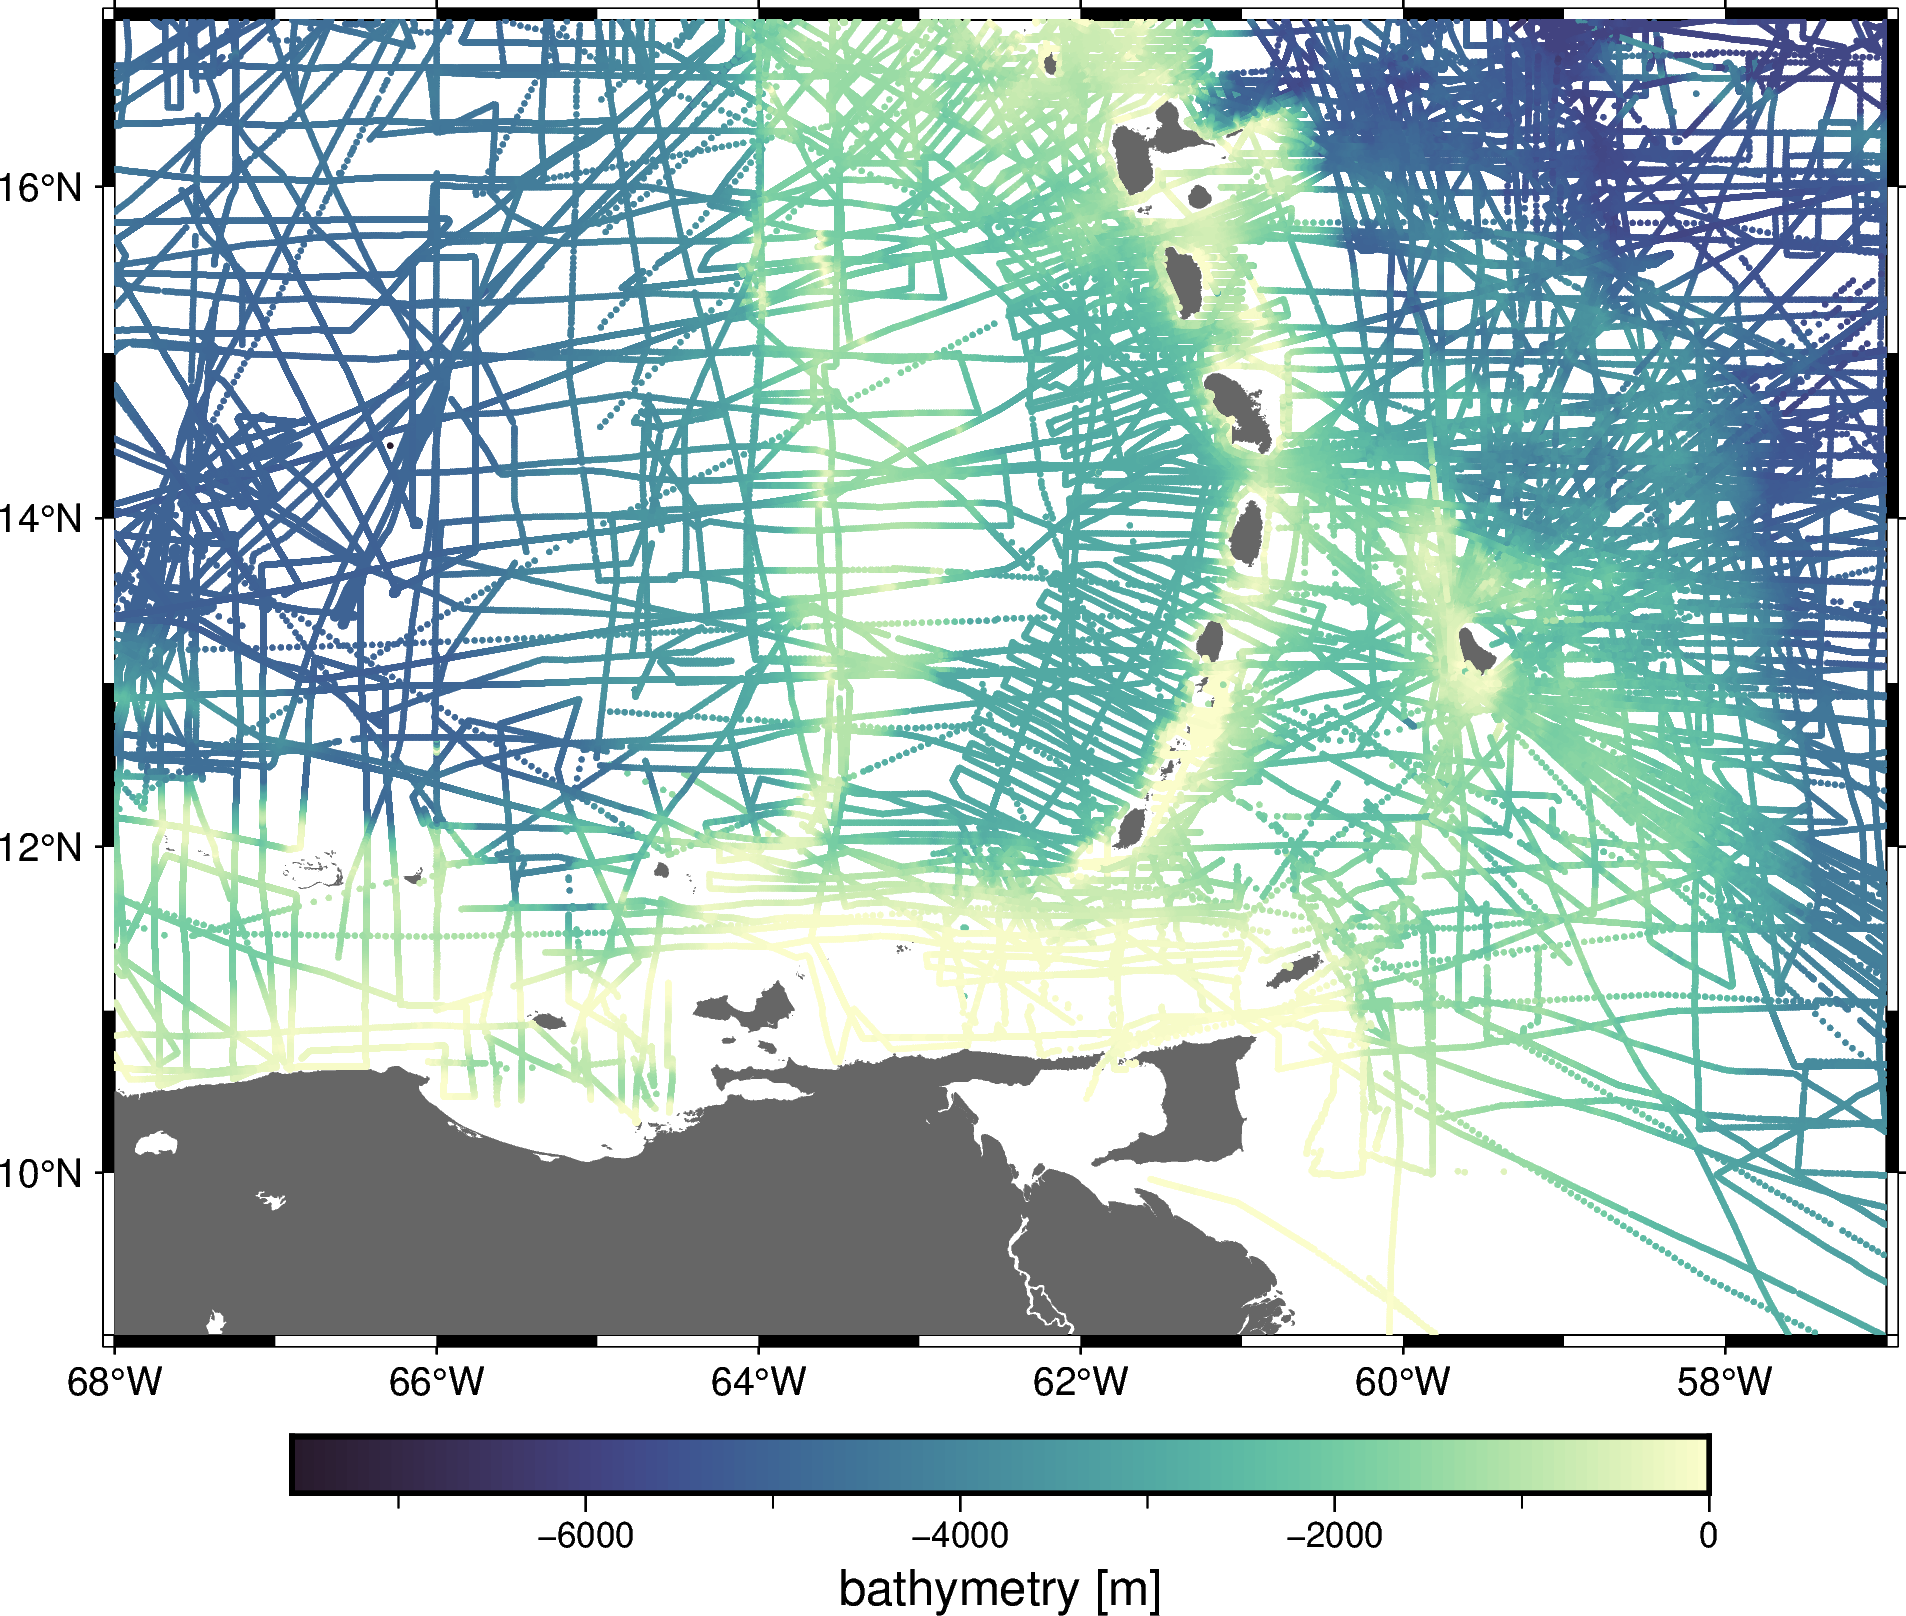

In [9]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame="af")
fig.coast(land="#666666")
pygmt.makecpt(cmap="cmocean/topo+h", series=[data_reloaded.bathymetry_m.min(), data_reloaded.bathymetry_m.max()])
fig.plot(
    x=data_reloaded.longitude,
    y=data_reloaded.latitude,
    fill=data_reloaded.bathymetry_m,
    cmap=True,
    style="c0.05c",
)
fig.colorbar(frame='af+l"bathymetry [m]"')
fig.show(width=800)